# Classifying if a space object is Hazardous or not

* Dataset -- https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, f1_score, plot_roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [10]:
df = pd.read_csv("/content/drive/MyDrive/NASA-Nearest-Objects/data/neo.csv")

In [21]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [14]:
df.orbiting_body.unique()

array(['Earth'], dtype=object)

In [15]:
df.isna().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

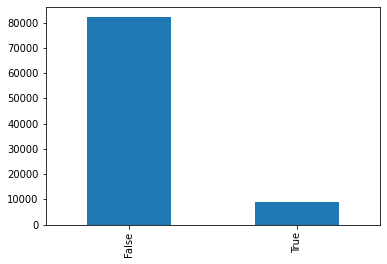

In [19]:
df.hazardous.value_counts().plot(kind = 'bar')

In [20]:
df.hazardous.value_counts()

False    81996
True      8840
Name: hazardous, dtype: int64

In [23]:
df.sentry_object.value_counts()

False    90836
Name: sentry_object, dtype: int64

In [24]:
pd.crosstab(df.miss_distance, df.hazardous)

hazardous,False,True
miss_distance,,
6.745533e+03,1,0
9.316925e+03,1,0
9.426685e+03,1,0
1.185167e+04,1,0
1.261343e+04,1,0
...,...,...
7.479223e+07,1,0
7.479529e+07,1,0
7.479530e+07,1,0


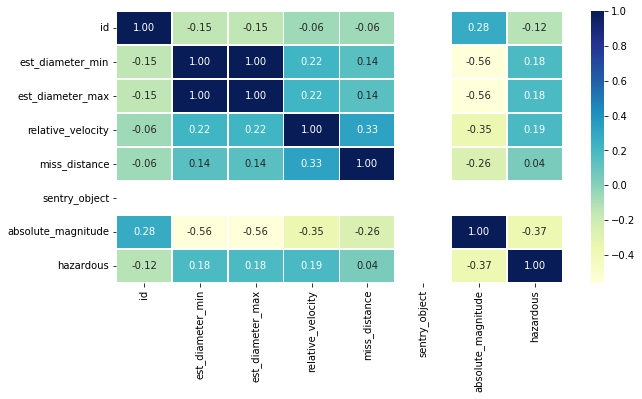

In [30]:
corr_matrix = df.corr()

fig, ax  = plt.subplots(figsize=(10,5))
ax = sns.heatmap(corr_matrix , cmap="YlGnBu",linewidths=0.5, fmt=".2f", annot=True)

In [31]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [46]:
df_dropped = df.drop(['id', 'orbiting_body', 'sentry_object', 'name'], axis = 1)

In [47]:
df_dropped.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


In [48]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   est_diameter_min    90836 non-null  float64
 1   est_diameter_max    90836 non-null  float64
 2   relative_velocity   90836 non-null  float64
 3   miss_distance       90836 non-null  float64
 4   absolute_magnitude  90836 non-null  float64
 5   hazardous           90836 non-null  bool   
dtypes: bool(1), float64(5)
memory usage: 3.6 MB


In [49]:
X = df_dropped.drop('hazardous', axis = 1)
y = df_dropped.hazardous

In [50]:
X.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09


In [51]:
y.head()

0    False
1     True
2    False
3    False
4     True
Name: hazardous, dtype: bool

In [52]:
np.random.seed(3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [53]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((72668, 5), (72668,), (18168, 5), (18168,))

In [71]:
models = {
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [72]:
def fit_score_models(models, X_train, X_test, y_train, y_test):

  """
  Get accuracy, precision, recall and f1 scores for given models
  """
  model_scores = {}
  np.random.seed(3)
  
  for name, model in models.items():
    model.fit(X_train, y_train)
    model_scores[name] = {}
    y_preds = model.predict(X_test)
    model_scores[name]['accuracy'] =  model.score(X_test, y_test)
    model_scores[name]['precision'] = precision_score(y_test, y_preds, )
    model_scores[name]['recall'] = recall_score(y_test, y_preds)
    model_scores[name]['f1_score'] = f1_score(y_test, y_preds)

  return model_scores



In [73]:
test_scores = fit_score_models(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test= y_test)

test_scores

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'KNN': {'accuracy': 0.8925583443416997,
  'f1_score': 0.06513409961685823,
  'precision': 0.22972972972972974,
  'recall': 0.03794642857142857},
 'LogisticRegression': {'accuracy': 0.9013650374284456,
  'f1_score': 0.0,
  'precision': 0.0,
  'recall': 0.0},
 'RandomForestClassifier': {'accuracy': 0.9198040510788199,
  'f1_score': 0.518028448561032,
  'precision': 0.636068237205524,
  'recall': 0.4369419642857143},
 'SVC': {'accuracy': 0.9013650374284456,
  'f1_score': 0.0,
  'precision': 0.0,
  'recall': 0.0}}

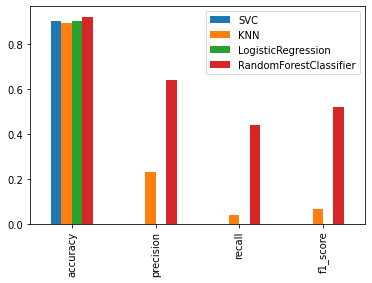

In [82]:
pd.DataFrame(test_scores).plot.bar()

After consideration we are going forward with the Random Forest Classifier as it has the best metrics by far








## Hyperparameter tuning 

In [100]:
rfr_grid = {
    "n_estimators": [100, 150,200],
     "max_depth": [None, 10],
    "min_samples_split": [2,4],
    "min_samples_leaf":[1,2,]
}

In [101]:
np.random.seed(3)

rfr_grid_model = GridSearchCV(RandomForestClassifier(), param_grid=rfr_grid, cv=5, verbose = True)

rfr_grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 150, 200]},
             verbose=True)

In [102]:
rfr_grid_model.best_params_

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 100}

In [103]:
rfr_grid_model.score(X_test, y_test)

0.9202994275649493

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


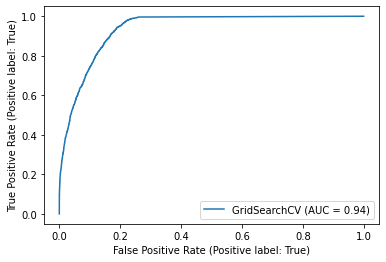

In [104]:
plot_roc_curve(rfr_grid_model, X_test, y_test)

In [148]:
def get_test_scores(model, X_test, y_test):

  np.random.seed(3)
  scores = {}
  y_preds = model.predict(X_test)

  scores['Accuracy'] = accuracy_score(y_test,y_preds)
  scores['F1-Score'] = f1_score(y_test, y_preds)
  scores['Precision'] = precision_score(y_test, y_preds)
  scores['Recall'] = recall_score(y_test, y_preds)
  scores['ROC-AUC-Score'] = roc_auc_score(y_test, y_preds)

  return scores




In [149]:
scores = get_test_scores(model = rfr_grid_model, X_test = X_test, y_test = y_test)
scores

{'Accuracy': 0.9202994275649493,
 'F1-Score': 0.4972222222222222,
 'Precision': 0.6580882352941176,
 'ROC-AUC-Score': 0.6884187007118431,
 'Recall': 0.39955357142857145}

(0.0, 1.5)

<Figure size 720x1080 with 0 Axes>

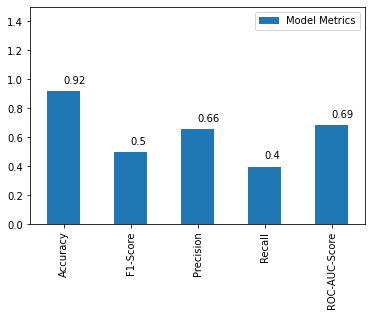

In [186]:
plt.figure(figsize=(10,15))
def add_value_label(x_list,y_list):
  for i in range(0, len(x_list)):
      plt.text(i,y_list[i] + 0.05,round(y_list[i], 2))



model_compare = pd.DataFrame(scores, index= ['Model Metrics'],)
model_compare.T.plot.bar()
add_value_label(list(scores.keys()), list(scores.values()))

plt.ylim(top=1.5)

In [188]:
dump(rfr_grid_model, '/content/drive/MyDrive/NASA-Nearest-Objects/models/Random-Forest_Classifier.sav')

['/content/drive/MyDrive/NASA-Nearest-Objects/models/Random-Forest_Classifier.sav']

In [189]:
loaded_model =  load("/content/drive/MyDrive/NASA-Nearest-Objects/models/Random-Forest_Classifier.sav")
loaded_model.score(X_test, y_test)

0.9202994275649493